In [1]:
%reload_ext autoreload
%autoreload 2

# Mode solver

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytrans.analysis import mode_solver

from pytrans.analysis.mode_solver import init_crystal
from pytrans.analysis.analytic_traps import HarmonicTrap

from pytrans.ions import Ca40

from scipy.constants import elementary_charge, pi, epsilon_0


## Equilibrium positions in harmonic trap

### From linear to zigzag:

Reference:

James, D. Quantum dynamics of cold trapped ions with application to quantum computation. Appl Phys B 66, 181–190 (1998). https://doi.org/10.1007/s003400050373

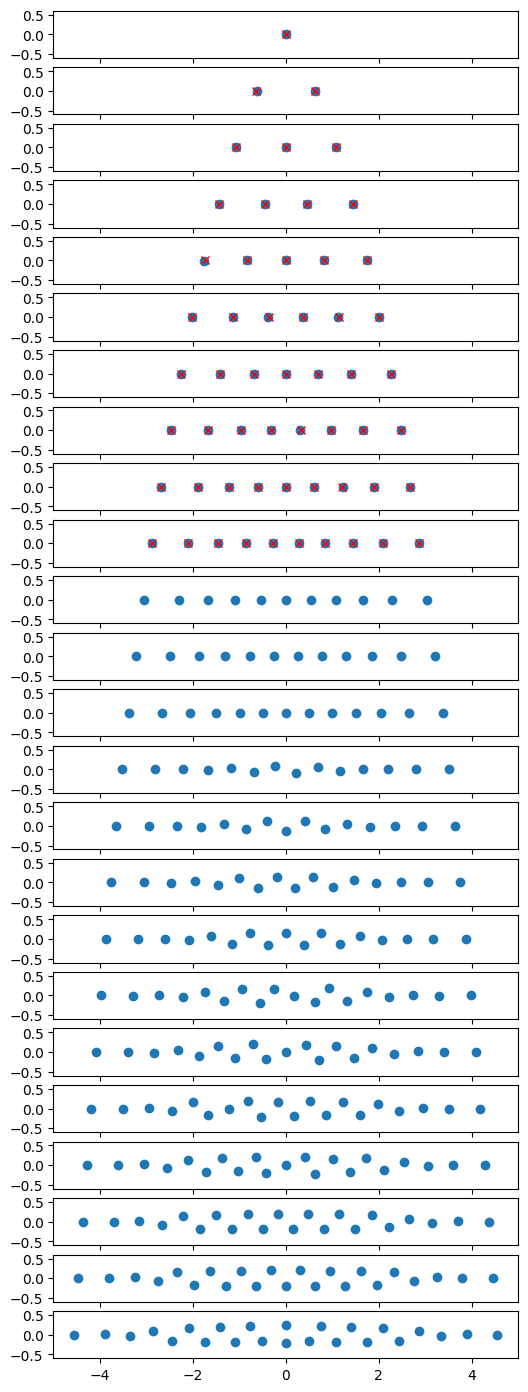

In [3]:

# From [James98], Table 1

scaled_equilibrium_positions = [
    [0.0],
    [-0.63, 0.63],
    [-1.0772, 0.0, 1.0772],
    [-1.4368, -0.4544, 0.4544, 1.4368],
    [-1.7429, -0.8221, -0.0, 0.8221, 1.7429],
    [-2.0123, -1.1361, -0.3699, 0.3699, 1.1361, 2.0123],
    [-2.2545, -1.4129, -0.6869, -0.0, 0.6869, 1.4129, 2.2545],
    [-2.4758, -1.6621, -0.967, -0.318, 0.318, 0.967, 1.6621, 2.4758],
    [-2.6803, -1.8897, -1.2195, -0.5996, -0.0, 0.5996, 1.2195, 1.8897, 2.6803],
    [-2.8708, -2.1001, -1.4503, -0.8538, -0.2823, 0.2823, 0.8538, 1.4503, 2.1001, 2.8708],
]


fx = 1e6
l_scale = (elementary_charge**2 / (4 * pi * epsilon_0) / (Ca40.mass * (2 * pi * fx)**2))**(1 / 3)

harmonic_trap = HarmonicTrap(fx, fy=6e6, fz=10e6, ion=Ca40)


N_max = 25
fig, axes = plt.subplots(N_max - 1, 1, figsize=(6, 0.7 * N_max), sharex=True, squeeze=False)

def solve_for_n_ions(trap, N_ions):
    dx = 2e-6
    x0 = init_crystal((0, 0, 0), dx, N_ions, axis=0, randomize=True)
    result = mode_solver(trap, x0=x0, voltages=None, ions=[Ca40] * N_ions, bounds=None)
    return result, x0

for j, N_ions in enumerate(range(1, N_max)):

    result, x0 = solve_for_n_ions(harmonic_trap, N_ions)
    
    x_eq = result.x_eq
    x_eq1 = x_eq[:, 0] / l_scale

    yy = x_eq[:, 1] / l_scale

    ax = axes[j, 0]
    # ax.plot(x0[:, 0] / l_scale, x0[:, 1] / l_scale, 'o', color='lightgray')
    ax.plot(x_eq1, yy, 'o')
    try:
        ax.plot(scaled_equilibrium_positions[j], np.zeros((N_ions)), 'xr', ms=6)
    except IndexError:
        pass
    ax.set_ylim(-0.6, 0.6)
# ax.invert_yaxis()

# result['res']

## Normal modes of long ion chains


### Single species in anharmonic potential

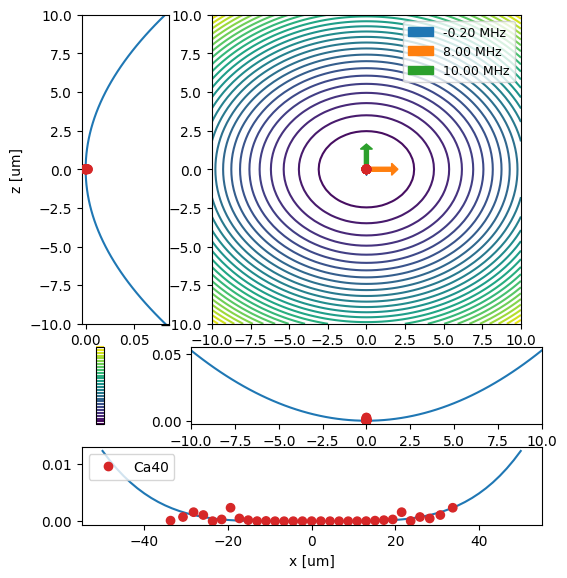

In [4]:
from pytrans.ions import Ca40
from pytrans.analysis import analyse_potential
from pytrans.analysis.analytic_traps import HarmonicTrap, QuarticTrap
from pytrans.plotting.plotting import _get_ion_color, _add_ions_legend

# wx, wy, wz = 1.3e6, 3.5e6, 4.19e6
wx, wy, wz = -0.2e6, 8e6, 10e6
hqtrap = HarmonicTrap(wx, wy, wz, ion=Ca40, tilt_yz=0) + QuarticTrap(5e16)

ions = [Ca40] * 31
r0 = (0, 0, 0)
roi = (50e-6, 1e-5, 1e-5)

res = analyse_potential(hqtrap, voltages=None, ions=ions, r0=r0, roi=roi, verbose=False, find_3dmin=False)
mres = res.mode_solver_results
    
trap_freqs = result.mode_freqs
mode_freqs = mres.mode_freqs
mode_vectors = mres.mode_vectors
x_eq = mres.x_eq


def project_on_single_ion_modes(mode_vectors, single_ion_modes, keys=None):
    # projections of normal modes on single-ion eigenmodes
    proj = abs(np.einsum('Mai,mi', mode_vectors, single_ion_modes)).sum(1)
    mode1_index = np.argmax(proj, axis=1)

    mode_vectors_projected = np.asarray([mode_vectors[j] @ single_ion_modes[mode1_index[j]] for j in range(len(mode_vectors))])

    mode_labels = {}
    keys = 'xyz' if keys is None else keys
    for j, key in enumerate(keys):
        mode_labels[key] = np.where(mode1_index == j)[0]
        
    return mode_vectors_projected, mode_labels


mode_vectors_projected, mode_labels = project_on_single_ion_modes(mode_vectors, res.mode_vectors, keys=['ax', 'r0', 'r1'])


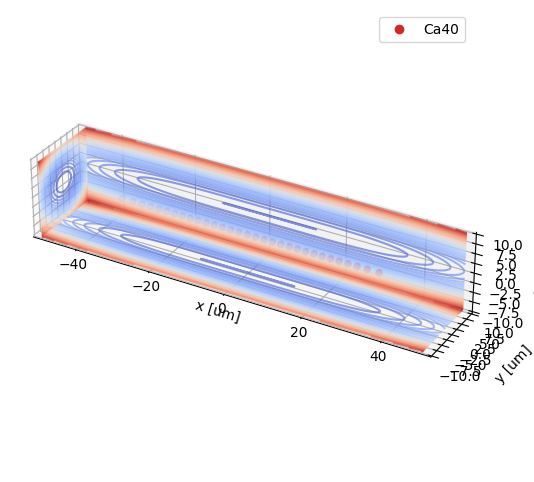

In [5]:
from pytrans.plotting import plot3d_potential

_ = plot3d_potential(hqtrap, None, Ca40, r0, roi, analyse_results=res)

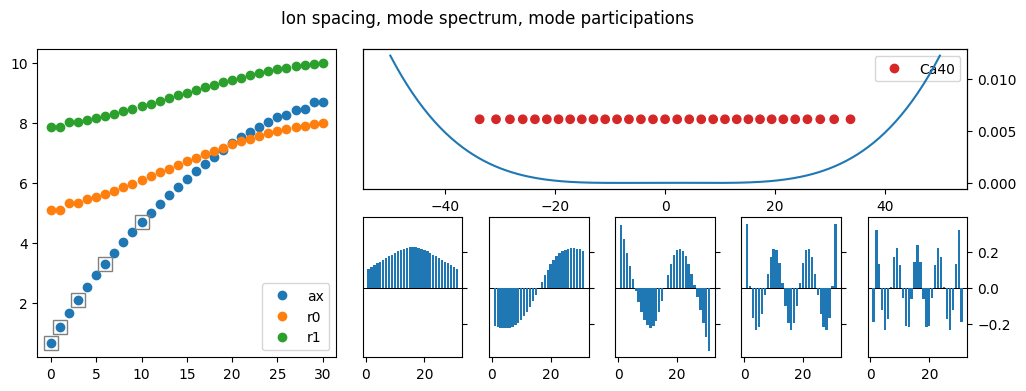

In [6]:

plot_modes = ['ax']
plot_indices = [0, 1, 3, 6, 10]
# plot_indices = list(range(n_ions))

mosaic = [['freqs'] + [0] * (len(plot_indices))]
# mosaic += [['freqs'] * len(plot_indices)]
mosaic += [
   ['freqs'] + [f"{mode}_{j}" for j in plot_indices] for mode in plot_modes
]
wr = [3] + [1] * len(plot_indices)
fig, axes = plt.subplot_mosaic(mosaic, figsize=(12, 4), width_ratios=wr)
fig.suptitle('Ion spacing, mode spectrum, mode participations')

ax0 = axes[0]
x, y = x_eq[:, [0, 1]].T * 1e6
ion_colors = [_get_ion_color(ion) for ion in ions]
ax0.scatter(x, y, c=ion_colors)
if y.ptp() < 0.1:
    ax0.set_ylim(-0.6, 0.6)
ax0.set_yticks([])
_add_ions_legend(ax0, ions)

x0 = roi[0]
xx = np.linspace(-roi[0], roi[0], 200)
pot = hqtrap.potential(None, xx, 0, 0, Ca40.mass_amu)
ax1 = ax0.twinx()
ax1.plot(xx*1e6, pot)

af = axes['freqs']
for mode in mode_labels.keys():
    fs = mode_freqs[mode_labels[mode]] * 1e-6
    af.plot(fs, 'o', label=mode)
af.legend()

for mode in plot_modes:
    mv1 = mode_vectors_projected[mode_labels[mode]]
    fs = mode_freqs[mode_labels[mode]] * 1e-6
    for j in plot_indices:
        m = mv1[j]
        ax = axes[f"{mode}_{j}"]
        ax.sharey(axes['ax_0'])
        ax.bar(np.arange(1, len(m) + 1), m)
        ax.axhline(0, color='k', lw=0.75, zorder=-1)

        af.plot(j, fs[j], 's', mfc='none', mec='gray', ms=10)
        ax.yaxis.tick_right()
        if j != plot_indices[-1]:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

### Mixed species

Reference:

K. Sosnova, A. Carter, and C. Monroe, "Character of motional modes for entanglement and sympathetic cooling of mixed-species trapped-ion chains", Phys. Rev. A 103, 012610 (2021) https://doi.org/10.1103/PhysRevA.103.012610


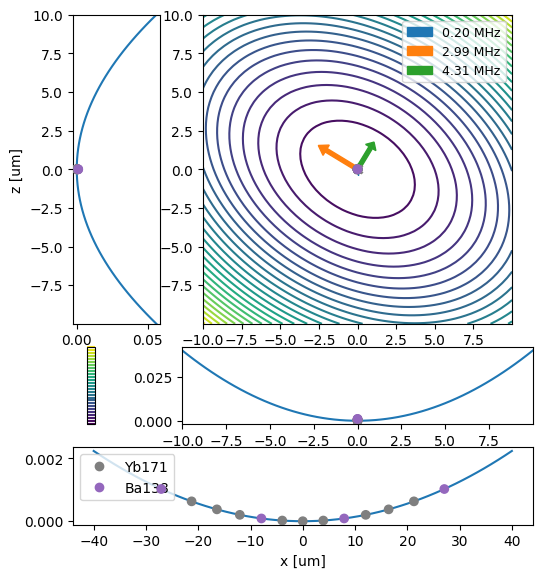

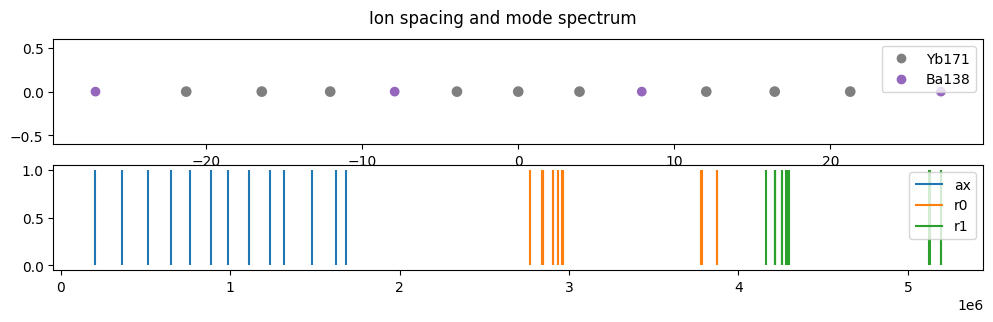

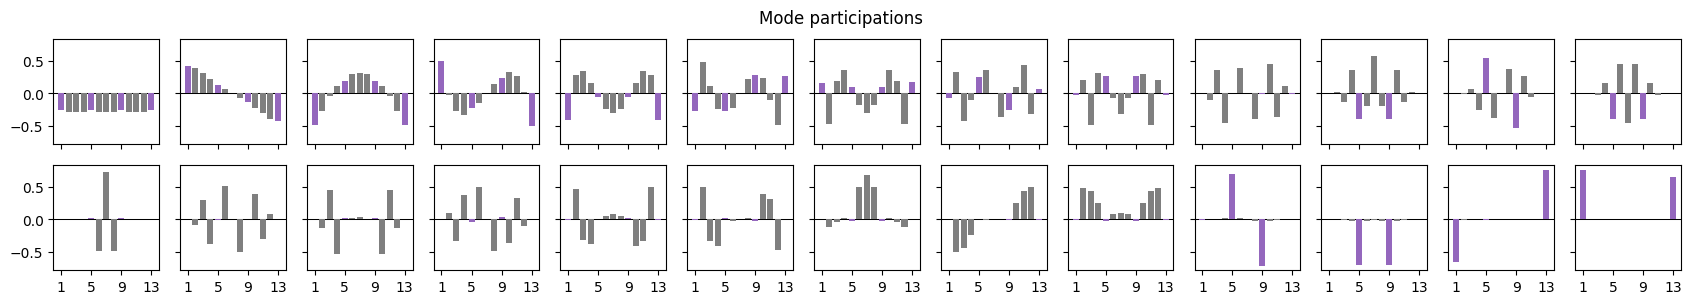

In [7]:
from pytrans.ions import Yb171, Ba138
from pytrans.analysis import analyse_potential

from pytrans.plotting.plotting import _get_ion_color, _add_ions_legend

# wx, wy, wz = 1.3e6, 3.5e6, 4.19e6
wx, wy, wz = 0.2e6, 3.396e6, 4.0e6
trap_freqs = np.asarray([wx, wy, wz])

trap = HarmonicTrap(wx, wy, wz, ion=Yb171, tilt_yz=3e8)
ions = [Ba138, Yb171, Yb171, Yb171] * 3 + [Ba138]

result = analyse_potential(trap, voltages=None, ions=ions, ion1=Yb171, r0=(0, 0, 0), roi=(40e-6, 1e-5, 1e-5), verbose=False)
# result = mode_solver(trap, voltages=None, ions=ions, x0=x0)

    

trap_freqs = result.mode_freqs
mode_freqs = result.mode_solver_results.mode_freqs
mode_vectors = result.mode_solver_results.mode_vectors
x_eq = result.mode_solver_results.x_eq


v1 = result.mode_vectors
mode_vectors_proj, mode_labels = project_on_single_ion_modes(mode_vectors, v1, keys=['ax', 'r0', 'r1'])

# --- plot
fig, (ax0, ax) = plt.subplots(2, 1, figsize=(12, 3))
fig.suptitle("Ion spacing and mode spectrum")


ion_colors = [_get_ion_color(ion) for ion in ions]
m_min = min([ion.mass_amu for ion in ions])
s = [(ion.mass_amu / m_min) * plt.rcParams['lines.markersize'] ** 2 for ion in ions]

ax0.scatter(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, c=ion_colors, s=s)
ax0.set_ylim(-0.6, 0.6)
_add_ions_legend(ax0, ions)

for j, (key, ix) in enumerate(mode_labels.items()):
    f = mode_freqs[ix]
    ax.vlines(f, 0, 1, label=key, color=f"C{j}")
ax.legend()


plot_modes = ['ax', 'r1']
nn = len(ions)

mosaic = [
    [f"{mode}_{j}" for j in range(nn)] for mode in plot_modes
]
fig, axes = plt.subplot_mosaic(mosaic, figsize=(21, 3), sharey=True, sharex=True)
fig.suptitle(f'Mode participations')


for mode in plot_modes:
    mode_vectors_1 = mode_vectors_proj[mode_labels[mode]]
    for j in range(nn):
        m = mode_vectors_1[j]
        ax = axes[f"{mode}_{j}"]
        ax.bar(np.arange(1, len(m) + 1), m, color=ion_colors)
        ax.axhline(0, color='k', lw=0.75, zorder=-1)
        ax.set_xticks([1, 5, 9, 13])


In [8]:
result

--------------
Trap potential analysis for ion Yb171: 
Equilibrium position [um]
[ 0.0002 -0.0009  0.0006]
Gradient [V/m]
[ 0.0005 -0.5083  0.4161]
Displacement at 1 MHz [um]
[ 0.     -0.0073  0.0059]
Hessian [V/m2]
[[2.7976e+06 0.0000e+00 0.0000e+00]
 [0.0000e+00 8.0662e+08 3.0000e+08]
 [0.0000e+00 3.0000e+08 1.1191e+09]]
Normal mode frequencies [MHz]
[0.2 2.98837 4.31305]
Eigenvectors
[[1 0 0]
 [0 -0.855 0.519]
 [0 0.519 0.855]]
Tilt angle of mode 2 (4.31): 58.75°
--------------
Mode solver analysis for ion crystal [Ba138, Yb171, Yb171, Yb171, Ba138, Yb171, Yb171, Yb171, Ba138, Yb171, Yb171, Yb171, Ba138]: 
Equilibrium positions [um]
[[-27.0803  -0.       0.    ]
 [-21.2688  -0.      -0.    ]
 [-16.4292   0.       0.    ]
 [-12.0453  -0.      -0.    ]
 [ -7.9149   0.       0.    ]
 [ -3.9256  -0.      -0.    ]
 [ -0.0008   0.       0.    ]
 [  3.9245  -0.      -0.    ]
 [  7.9135   0.       0.    ]
 [ 12.0438  -0.       0.    ]
 [ 16.4272  -0.      -0.    ]
 [ 21.2665  -0.      -0.  